# YouTube Video Category Classification

Pada notebook ini, kita akan mulai untuk membuat model *machine learning* yang akan mengklasifikasikan kategori video YouTube berdasarkan **judul** dan **deskripsi** video. Data yang akan digunakan adalah data [video trending YouTube Indonesia](https://www.kaggle.com/syahrulhamdani/indonesias-trending-youtube-video-statistics).

````{tip}
Setelah selesai mengunduh, sangat disarankan untuk diletakkan dalam folder `data` yang sejajar dengan notebook ini.
```bash
|- modelling.ipynb
|- data
    |- youtube
        |- trending.csv
        |- category.json
```
````


## Import Libraries

Pertama, kita akan import beberapa library yang akan digunakan pada notebook ini.

In [1]:
from textwrap import wrap

import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

/Users/bitlabsinstructor/.pyenv/versions/3.8.11/envs/bitlabs-webinar/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Data Loading

Untuk `trending.csv`, kita bisa langsung membaca data tersebut menggunakan `pandas`. Khusus untuk `category.json`, kita akan definisikan fungsi berikut untuk membantu kita membaca data kategori video.

```python
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }
```

```{note}
Karena alasan teknis, kita hanya akan menggunakan data video trending dari bulan Juli sampai Desember saja.
```

In [2]:
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }

In [3]:
category_dict = get_category_dict("data/category.json")

In [4]:
trending = pd.read_csv("./data/trending.csv", parse_dates=["publish_time", "trending_time"])

with pd.option_context("display.max_columns", None):
    display(trending.head())

,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time
0,2021-02-05 09:00:34+00:00,UCEf_Bc-KVd7onSeifS3py9g,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",NaN,NaN,NaN,SMTOWN,NaN,10,none,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",PT5M7S,2d,hd,True,True,NaN,NaN,7806846.0,857902.0,24078.0,0,94961.0,2021-02-07 05:46:51.832614+00:00
1,2021-02-04 15:54:08+00:00,UCYEa4_MC7OFjcWrO6SO-u8g,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",NaN,NaN,NaN,Indonesia Lawyers Club,"['tvone', 'tv one', 'tvonenews', 'indonesia la...",25,none,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",PT42M30S,2d,hd,False,True,NaN,NaN,885038.0,6765.0,1263.0,0,6365.0,2021-02-07 05:46:51.832649+00:00
2,2021-02-06 03:00:22+00:00,UCu12RxQjRQyh79YBYvEDkOg,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,NaN,NaN,NaN,Motomobi,"['MotoMobi', 'Mobil', 'motor', 'review', 'indo...",2,none,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,PT46M43S,2d,hd,False,True,NaN,NaN,889708.0,47895.0,532.0,0,8785.0,2021-02-07 05:46:51.832664+00:00
3,2021-02-05 20:26:08+00:00,UCCuzDCoI3EUOo_nhCj4noSw,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,NaN,NaN,NaN,yb,NaN,20,none,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,PT45M59S,2d,hd,False,True,NaN,NaN,1006854.0,91973.0,3967.0,0,12957.0,2021-02-07 05:46:51.832678+00:00
4,2021-02-03 23:14:54+00:00,UC14UlmYlSNiQCBe9Eookf_A,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",NaN,NaN,NaN,FC Barcelona,"['FC Barcelona', 'برشلونة،', 'Fútbol', 'FUTBOL...",17,none,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",PT5M12S,2d,hd,False,True,NaN,NaN,6275035.0,218131.0,4289.0,0,12799.0,2021-02-07 05:46:51.832730+00:00


In [5]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = Timestamp('2021-02-07 05:46:51.832614+0000', tz='UTC')
end_date = Timestamp('2021-12-06 06:01:25.828896+0000', tz='UTC')


Bisa kita lihat bahwa data video trending dimulai dari bulan **Februari** sampai **Desember**. Untuk itu, kita akan *drop* data dari bulan **Februai sampai Juni**.

In [6]:
filtered_trending = trending[trending.trending_time.dt.month >= 7]

start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = Timestamp('2021-07-01 06:01:25.524449+0000', tz='UTC')
end_date = Timestamp('2021-12-06 06:01:25.828896+0000', tz='UTC')


In [7]:
num_videos = filtered_trending.shape[0]
print(f"{num_videos = }")

num_videos = 31600


Terdapat $31.600$ video yang masuk daftar trending setiap harinya dari bulan Juli sampai Desember. Selanjutnya, kita akan lakukan eksplorasi data terlebih dahulu sebelum mulai membuat model *machine learning*.

Selanjutnya, mari kita lihat bagaimana distribusi *missing value* pada masing-masing kolom.

In [8]:
filtered_trending.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31600 entries, 21322 to 52921
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   publish_time       31600 non-null  datetime64[ns, UTC]
 1   channel_id         31600 non-null  object             
 2   title              31600 non-null  object             
 3   description        30194 non-null  object             
 4   thumbnail_url      0 non-null      float64            
 5   thumbnail_width    0 non-null      float64            
 6   thumbnail_height   0 non-null      float64            
 7   channel_name       31600 non-null  object             
 8   tags               27542 non-null  object             
 9   category_id        31600 non-null  int64              
 10  live_status        31600 non-null  object             
 11  local_title        31600 non-null  object             
 12  local_description  30194 non-null  object 

Dari informasi di atas, ada beberapa video yang kolom deskripsinya kosong. Untuk alasan *modeling* nanti, kita akan hapus video yang tidak memiliki teks deskripsi.

In [9]:
filtered_trending.dropna(subset=["description"], inplace=True)

## Exploratory Data Analysis

Pertama, karena setiap hari, bahkan setiap beberapa jam, daftar trending di YouTube selalu ada pembaruan, mari kita lihat jumlah video dari hari per hari. Langkah-langkahnya yaitu:
* Kelompokkan data berdasarkan tanggal per hari
* Hitung jumlah video pada tanggal tersebut

In [10]:
trending_by_date = filtered_trending.groupby(
    filtered_trending.trending_time.dt.date
)
num_trending_per_day = trending_by_date.trending_time.count()
print("Number of videos in trending per day:", num_trending_per_day.unique())

Number of videos in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183]


Jadi, setiap harinya, terdapat **200 video** yang masuk dalam daftar trending YouTube dari tanggal 1 Juli sampai 6 Desember.


### Trending Duration

Video masuk trending YouTube kadang kala juga bisa bertahan beberapa hari. Lama bertahannya video dalam daftar trending ini mungkin disebabkan oleh beberapa faktor seperti jumlah like, jumlah view, kecepatan kenaikan kedua metrik tersebut, dan lainnya. Mari kita lihat berapa lama durasi suatu video bertahan dalam trending YouTube.

In [11]:
trending_duration = filtered_trending.groupby("title").agg(
    trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
    trending_start_date=pd.NamedAgg(column="trending_time", aggfunc="min"),
    trending_last_date=pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()

trending_duration.head(10)

,title,trending_duration,trending_start_date,trending_last_date
0,Måneskin - Beggin' (Lyrics/Testo),30,2021-07-06 06:01:08.609842+00:00,2021-08-14 06:01:09.572758+00:00
1,Måneskin - Beggin' (Lyrics),30,2021-07-09 06:03:40.293908+00:00,2021-09-29 06:00:48.508222+00:00
2,"The Kid LAROI, Justin Bieber - Stay (Lyrics)",22,2021-08-07 06:00:58.727254+00:00,2021-11-02 06:00:52.042819+00:00
3,Happy Asmara - Lemah Teles (Official Music Liv...,21,2021-07-19 06:02:49.428626+00:00,2021-08-08 06:01:02.782146+00:00
4,WONDERLAND INDONESIA by Alffy Rev (ft. Novia B...,21,2021-08-18 06:00:55.039010+00:00,2021-09-07 06:00:48.332429+00:00
5,DENNY CAKNAN FT. NDARBOY GENK - MENDUNG TANPO ...,20,2021-07-28 06:00:52.529306+00:00,2021-08-16 06:01:24.371425+00:00
6,Join the BTS #PermissiontoDance Challenge only...,20,2021-08-07 06:00:58.726624+00:00,2021-08-26 06:00:52.511071+00:00
7,"MERINDING GUE DENGER INI, GOKIL‼️ SEREM ABIS‼️...",20,2021-07-02 06:01:02.071087+00:00,2021-07-21 06:01:23.252876+00:00
8,Create your own short to Shivers using #Sheera...,20,2021-10-26 06:00:53.187313+00:00,2021-11-14 06:01:05.587878+00:00
9,BTS (방탄소년단) 'Permission to Dance' Official MV,20,2021-07-10 06:01:04.439918+00:00,2021-07-29 06:00:56.665583+00:00


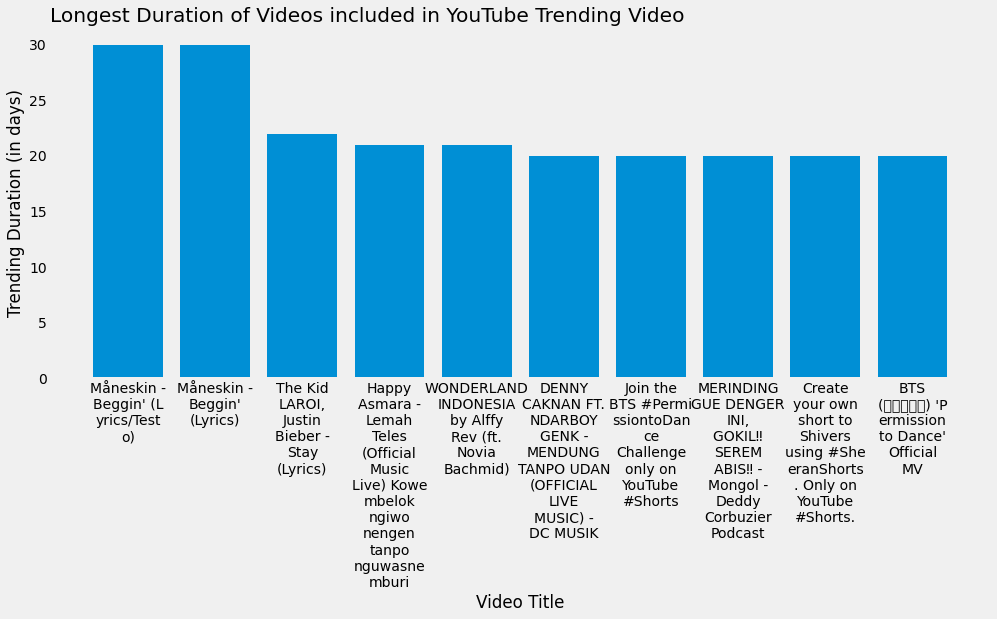

In [12]:
plt.figure(figsize=(15, 6))
plt.bar(
    trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
    trending_duration.trending_duration[:10]
)
plt.title("Longest Duration of Videos included in YouTube Trending Video", loc="left")
plt.xlabel("Video Title")
plt.ylabel("Trending Duration (in days)")
plt.grid(False)
plt.show()

```{tip}
Silakan eksplor lebih jauh lagi untuk durasi sebuah video bertahan dalam daftar trending dalam hal kategori video, channel, dan lainnya.
```


### Most Viewed, Liked, and Disliked Video

Metrik ini tentu sangat umum dan dijunjung tinggi oleh para kreator konten YouTube. Dengan metrik tersebut, kita juga bisa membuat *YouTube Rewind 2021* versi sederhana kita sendiri.

In [13]:
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min", "max", "mean", "sum"])
trending_rewind

view             \
                                                          min        max   
title                                                                      
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...   503651.0   822845.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...  1398186.0  1398186.0   
...                                                       ...        ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      1011999.0  1885538.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...  7.171452e+05   3585726.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...  1.398186e+06   1398186.0   
...                                                          ...         ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      1.567651e+06  10973554.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...    6952.0    9144.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...   44228.0   44228.0   
...                                                      ...       ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      127578.0  186596.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...    8436.200000    42181.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...   44228.000000    44228.0   
...                                                           ...        ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      165558.857143  1158912.0   
🥰 New Gadgets & Versatile Utensils

Jika kita lihat data di atas, ada beberapa video yang jumlah minimal dan maksimum `view`, `like`, maupun `dislike` yang berbeda. Ini bisa saja dikarenakan video tersebut yang bertahan beberapa hari dalam trending, seperti video `"Emosi Rico Simanjutak" Saat ...` yang dimulai dengan jumlah `view` 72.434 pada awal masuk trending dan pada hari terakhir dalam trending mencapai jumlah `view` 116.310.

Sekarang, mari kita lihat jumlah maksimal `view`, `like`, dan `dislike` dari video teratas masing-masing tersebut dan bandingkan dengan pada saat awal masuk trending.

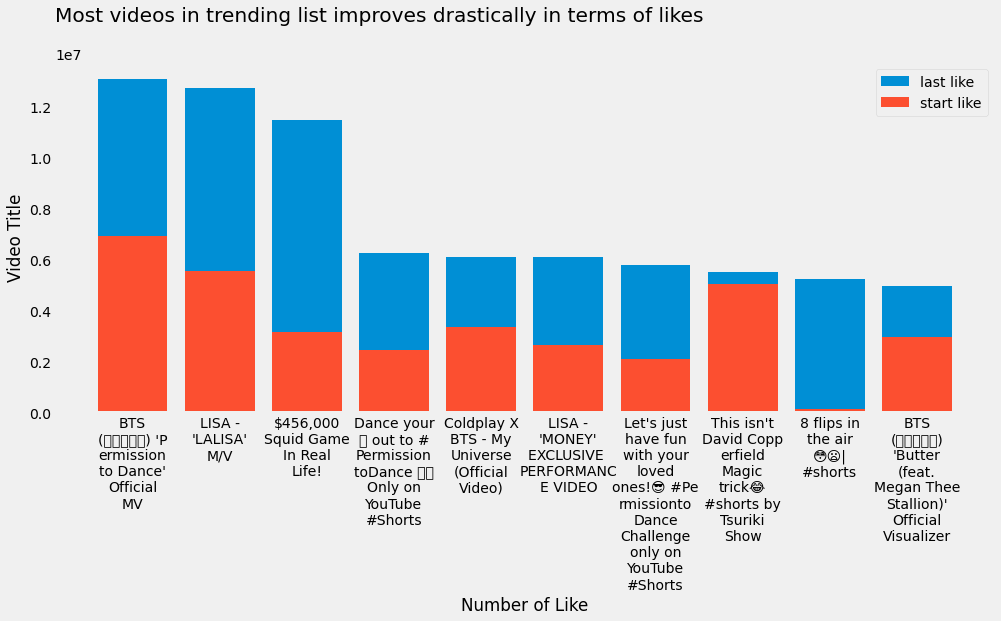

In [14]:
top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["max"],
    label="last like"
)
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["min"],
    label="start like"
)
plt.title("Most videos in trending list improves drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Number of Like")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

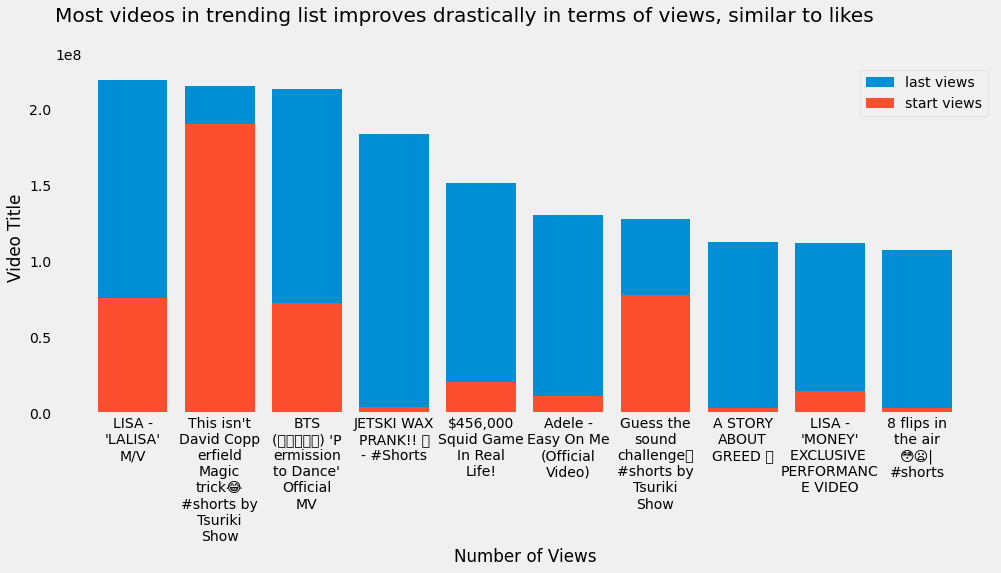

In [15]:
top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["max"],
    label="last views"
)
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="start views"
)
plt.title("Most videos in trending list improves drastically in terms of views, similar to likes", loc="left", y=1.1)
plt.xlabel("Number of Views")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

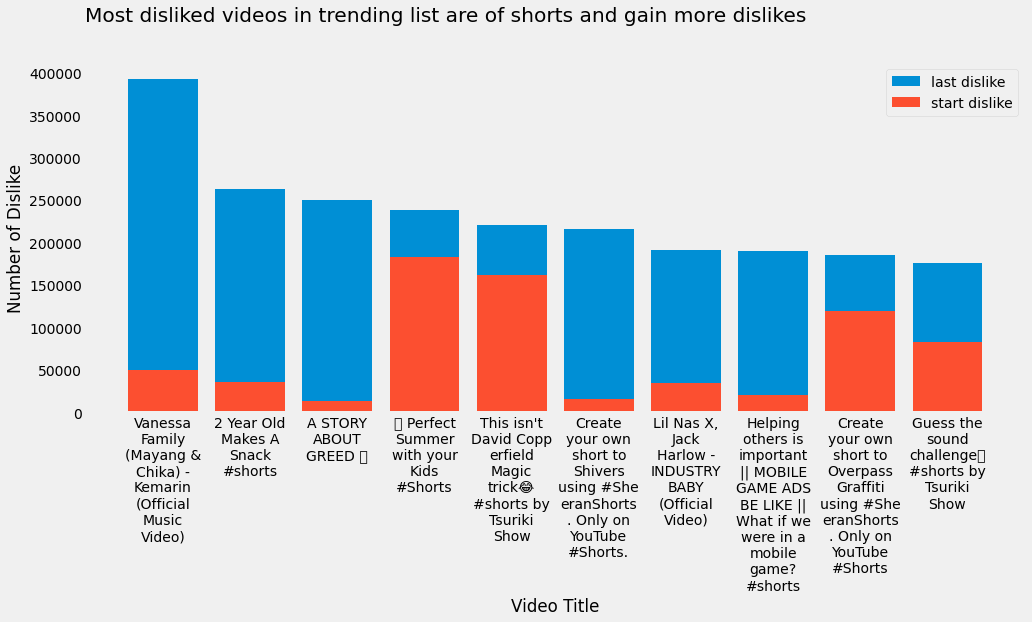

In [16]:
top_10_disliked = trending_rewind["dislike"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["max"],
    label="last dislike"
)
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["min"],
    label="start dislike"
)
plt.title("Most disliked videos in trending list are of shorts and gain more dislikes", loc="left", y=1.1)
plt.ylabel("Number of Dislike")
plt.xlabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

```{tip}
Kamu bisa melakukan eksplorasi lebih jauh lagi, seperti:
* most viewed, liked, and disliked channels
* video age from published until it's trending
* dan lainnya
```

## Data Preparation

Data judul dan deskripsi yang akan kita proses nantinya termasuk ke dalam *unstructured data* atau teks. Pemrosesan data teks ini termasuk ke dalam bidang NLP (*Natural Language Processing*)

```{figure} assets/gif/nlp-overview.gif
:name: nlp-overview
:alt: Overview NLP

Aplikasi *Natural Langauge Processing* ([ref](https://s3.amazonaws.com/codecademy-content/courses/NLP/Natural_Language_Processing_Overview.gif))
```

### Language Detection

Setelah melakukan eksplorasi, sekarang saatnya kita menyiapkan data yang akan digunakan untuk mengklasifikaskan kategori video, yaitu `title` dan `description`.

```{attention}
Kita hanya akan menggunakan video yang judul dan deskripsinya menggunakan bahasa Indonesia.
```

Karena kita hanya akan menggunakan teks berbahasa Indonesia, kita perlu menyaring mana yang berbahasa Indonesia dan mana yang bukan. Ada banyak *library* yang bisa kita gunakan, salah satunya adalah [`spacy`](https://spacy.io/). Tapi, karena alasan teknis, kita hanya akan menggunakan *library* yang lebih sederhana, yaitu [`langdetect`](https://github.com/Mimino666/langdetect).

````{note}
Jika kamu belum menginstall `langdetect`, install dengan perintah berikut:
```bash
pip install langdetect
```
````

Sebagai contoh, perhatikan sampel judul dan deskripsi video berikut.

In [17]:
sample = filtered_trending.sample(10, random_state=11)
sample[["title", "description"]]

,title,description
36912,REAKSI ORANG JEPANG NYOBAIN JUS ALPUKAT,Begini reaksi Yoshi pertama kali nyobain jus a...
38941,Pengamen yang bisa mainin lagu ini gue kasih 1...,Pengamen sekarang keren-keren banget alatnya l...
48089,TREASURE - WEB DRAMA '남고괴담' CHARACTER INTERVIEW,남고괴담 비하인드 스토리 구매하기\nhttps://weverseshop.onelin...
24766,(YB & Heiakim) Hello Goodbye - Sungha Jung X YB,(YB & Heiakim) Hello Goodbye - Sungha Jung X Y...
50307,Memecahkan Misteri Tantangan 1000 Kunci #2 Mul...,"Jika ada brankas tertutup di depanmu, kau past..."
47844,aespa 에스파 'Savage' Squid Game ver. Dance Practice,'Savage' MV hits 100M views!\nThank you so muc...
46357,PMPL SEA Championship S4 | Superweekend 3 Day ...,SUPERWEEKEND TERAKHIR PENENTUAN 1 TIKET PERTAM...
23245,"DAY6 (Even of Day) ""Right Through Me(뚫고 지나가요)""...","DAY6 (Even of Day) ""Right Through Me(뚫고 지나가요)""..."
24599,DJ SETIAP YANG KU LAKUKAN UNTUK DIRIMU VIRAL ...,----------------------------------------------...
27364,EP. 24 : Nekat Riding ke Area Rawan di Colombia,#WheelStory #MarioIroth #HondaAfricaTwin\n\nSe...


In [18]:
sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))

In [19]:
with pd.option_context("display.max_colwidth", 100):
    display(sample[["title", "title_lang", "description", "desc_lang"]])

,title,title_lang,description,desc_lang
36912,REAKSI ORANG JEPANG NYOBAIN JUS ALPUKAT,id,"Begini reaksi Yoshi pertama kali nyobain jus alpukat! \nKalo di Jepang, alpukat dimakannya pake ...",id
38941,Pengamen yang bisa mainin lagu ini gue kasih 100 dollar | #Nantangin,id,Pengamen sekarang keren-keren banget alatnya lengkap.\nShoutout to pengamen-pengamen Bandung.\n\...,id
48089,TREASURE - WEB DRAMA '남고괴담' CHARACTER INTERVIEW,en,남고괴담 비하인드 스토리 구매하기\nhttps://weverseshop.onelink.me/BZSY/9595f182 \n\n#TREASURE #트레저 #남고괴담 #TheMy...,en
24766,(YB & Heiakim) Hello Goodbye - Sungha Jung X YB,so,(YB & Heiakim) Hello Goodbye - Sungha Jung X YB\n\nTuning : Standard\n\nOriginal : https://youtu...,en
50307,Memecahkan Misteri Tantangan 1000 Kunci #2 Multi DO Challenge,id,"Jika ada brankas tertutup di depanmu, kau pasti ingin tahu apa isinya! Pahlawan kita juga sangat...",id
47844,aespa 에스파 'Savage' Squid Game ver. Dance Practice,fr,'Savage' MV hits 100M views!\nThank you so much for your love and support 😘\n\nListen and downlo...,en
46357,PMPL SEA Championship S4 | Superweekend 3 Day 1 | FULL TEAM INDONESIA DI SUPERWEEKEND,en,SUPERWEEKEND TERAKHIR PENENTUAN 1 TIKET PERTAMA MENUJU PMGC! Seteleh 2 hari Weekdays yang cukup ...,id
23245,"DAY6 (Even of Day) ""Right Through Me(뚫고 지나가요)"" LIVE CLIP",en,"DAY6 (Even of Day) ""Right Through Me(뚫고 지나가요)"" LIVE CLIP\n\nListen to DAY6 (Even of Day) ""Right ...",en
24599,DJ SETIAP YANG KU LAKUKAN UNTUK DIRIMU VIRAL TIKTOK BAHAGIA SLOW BEAT SYAHDU,id,-------------------------------------------------------------\n Judul : DJ SETIAP YANG KU LAKUKA...,id
27364,EP. 24 : Nekat Riding ke Area Rawan di Colombia,id,#WheelStory #MarioIroth #HondaAfricaTwin\n\nSetelah Ecuador negara selanjutnya yang saya jelajah...,id


```{note}
Perhatikan bahwa sebelum `langdetect.detect`, `title` dan `deskripsi` dijadikan *lowercase*. Ini dilakukan supaya `langdetect` dapat mendeteksi bahasa secara maksimal.
```

Ada beberapa kasus yang mungkin terjadi untuk deteksi bahasa pada judul dan deskripsi di atas:
* Judul berbahasa Indonesia, sedangkan deskripsi dideteksi sebagai bahasa asing (yang mungkin seharusnya bahasa Indonesia)
* Deksripsi dideteksi sebagai bahasa Indonesia, sedangkan judul berbahasa asing (yang mungkin seharusnya bahasa Indonesia)
* Baik judul atau deskripsi dideteksi sebagai bahasa asing, yang seharusnya salah satu atau keduanya berbahasa Indonesia

Untuk kemungkinan ketiga, kita tidak akan menggunakan video yang judul dan deskripsinya dideteksi sebagai bahasa asing, meskipun seharusnya salah deteksi.  Sekarang, mari kita deteksi bahasa untuk semua video dalam `filtered_trending`.

Pertama, kita akan buat fungsi yang akan mendeteksi bahasa dari sebuah teks sebagai berikut.

```python
def detect_language(text):
    """Detect language of the `text`."""
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return
```

In [20]:
def detect_language(text):
    """Detect language of the `text`."""
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return

In [21]:
filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language)

In [22]:
filtered_trending[["title", "title_lang", "description", "desc_lang"]]

,title,title_lang,description,desc_lang
21322,NCT DREAM 엔시티 드림 'Hello Future' MV,it,"NCT DREAM's 1st Album Repackage ""Hello Future""...",en
21323,PART 3 // SUTRISNO DAN ENDANG BAHAGIA,de,Find me on sosial media :\n\nInstagram : https...,en
21324,This isn't David Copperfield Magic trick😂 #sho...,en,Thank you for watching.\nSubscribe to Tsuriki ...,en
21325,Rizky Billar - Pemimpinmu | Official Music Video,en,Rizky Billar - Pemimpinmu | Official Music Vid...,id
21326,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,id,Polisi menangkap pengemudi SUV yang merusak da...,id
...,...,...,...,...
52916,ARSY DAN THALIA ONSU DUET SAMPAI BIKIN RAFFI A...,de,Gemes! Arsy dan Thalia Putri Onsu duet nyanyi ...,id
52918,Beli barang aneh yang dijual ONLINE Episode 20!,id,Banyak lap nya.\n\nDapatkan Betadine Cold Defe...,id
52919,Layangan Putus | Highlight EP02 Senyum Bahagia...,id,"Yuk tonton full episodenya, GRATIS melalui app...",id
52920,"PAULA LEMES , GA BISA NGOMONG APA2..",hu,=================================\r\n\r\nSocia...,id


Setelah kita selesai mendeteksi bahasa pada `title` dan `description`, langkah selanjutnya adalah membuang data yang `title` atau `description` bukan `id`, yaitu tidak berbahasa Indonesia.

In [23]:
indo_trending = filtered_trending.loc[
    (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]

with pd.option_context("display.max_columns", None):
    display(indo_trending.sample(10))

,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
38215,2021-09-18 06:02:15+00:00,UCFQoE23adk7NSPNhBlanu4w,IBU MUDA VIRAL❗JOGED TIKTOK ABIS B▪NUH ANAKNYA...,Daftar di Binomo dan dapatkan bonus $1000 di a...,NaN,NaN,NaN,Hirotada Radifan,"['hirotada', 'hirotada radifan', 'radifan', 't...",24,none,IBU MUDA VIRAL❗JOGED TIKTOK ABIS B▪NUH ANAKNYA...,Daftar di Binomo dan dapatkan bonus $1000 di a...,PT11M16S,2d,hd,False,True,NaN,NaN,1293236.0,50167.0,759.0,0,3037.0,2021-09-23 06:00:50.024122+00:00,de,id
44304,2021-10-16 08:56:56+00:00,UCM3SMB1jINy_NxH1O01z5gA,[2021] Free Fire Indonesia Masters 2021 Fall -...,"Hi Survivors!\n\nFase Play-ins, pada turnamen ...",NaN,NaN,NaN,Garena Free Fire Indonesia,NaN,20,none,[2021] Free Fire Indonesia Masters 2021 Fall -...,"Hi Survivors!\n\nFase Play-ins, pada turnamen ...",PT4H3M36S,2d,hd,False,False,NaN,NaN,463970.0,19533.0,545.0,0,394.0,2021-10-23 06:00:47.461176+00:00,en,id
37719,2021-09-09 13:19:31+00:00,UCwljrkoI5jsfvAKgW3zNC7Q,DITA & JINNY SECRET NUMBER - JANGAN | Shopee 9...,LOCKEY! Siapa yang setuju kalau Dita dan Jinny...,NaN,NaN,NaN,SHOPEE Indonesia,"['Shopee Indonesia', 'secret number shopee', '...",24,none,DITA & JINNY SECRET NUMBER - JANGAN | Shopee 9...,LOCKEY! Siapa yang setuju kalau Dita dan Jinny...,PT3M37S,2d,hd,False,False,NaN,NaN,1008551.0,NaN,NaN,0,8948.0,2021-09-20 06:00:52.963641+00:00,en,id
50167,2021-11-19 10:00:09+00:00,UC72Yq2bhmBDkpvm6F0pSH4Q,K-POP Eksklusif - Secret Number main tali kare...,Subscribe channel KBS World Indonesian supaya ...,NaN,NaN,NaN,KBS WORLD Indonesian,"['yt:cc=on', 'kbs world', 'kbs', 'kbs world in...",24,none,K-POP Eksklusif - Secret Number main tali kare...,Subscribe channel KBS World Indonesian supaya ...,PT14M58S,2d,hd,False,True,NaN,NaN,366522.0,39710.0,216.0,0,2278.0,2021-11-23 06:00:54.632343+00:00,id,id
51575,2021-11-25 14:17:14+00:00,UCuMAjEaSMj7q7YLf0xW1MjQ,Murka Kapolres Jakpus Usai Polisi Dikeroyok Pe...,Tonton video lengkapnya disini: https://bit.ly...,NaN,NaN,NaN,detikcom,"['detikcom', '20detik', 'Murka', 'Kapolres', '...",25,none,Murka Kapolres Jakpus Usai Polisi Dikeroyok Pe...,Tonton video lengkapnya disini: https://bit.ly...,PT2M50S,2d,hd,False,True,NaN,NaN,1941275.0,9187.0,552.0,0,14449.0,2021-11-30 06:01:20.103123+00:00,id,id
36804,2021-09-15 02:00:12+00:00,UCA1j_75REY9xurdvnr_H8ig,Andika Mahesa ft Dodhy - Pamit Pergi (Official...,Andika Mahesa ft Dodhy // Kangen Band - Pamit ...,NaN,NaN,NaN,Teras Musik,"['andika mahesa', 'kangen band', 'babang tamva...",10,none,Andika Mahesa ft Dodhy - Pamit Pergi (Official...,Andika Mahesa ft Dodhy // Kangen Band - Pamit ...,PT6M8S,2d,hd,True,True,NaN,NaN,118085.0,5932.0,80.0,0,1370.0,2021-09-16 06:00:57.290749+00:00,en,id
28239,2021-08-03 14:00:17+00:00,UCXGR-HNaTPVJoT7rQo3kaFQ,Virus Berasal dari Kebocoran Lab Wuhan: Laporan,Virus Berasal dari Kebocoran Lab Wuhan: Lapora...,NaN,NaN,NaN,NTDIndonesia,"['panic buying', 'panic buying oksigen', 'pand...",25,none,Virus Berasal dari Kebocoran Lab Wuhan: Laporan,Virus Berasal dari Kebocoran Lab Wuhan: Lapora...,PT2M40S,2d,hd,False,True,NaN,NaN,137861.0,1449.0,58.0,0,726.0,2021-08-04 06:00:57.776067+00:00,id,id
37495,2021-09-17 12:15:12+00:00,UCCeVzmN4eRxVKMvaVYXfiDg,Asep Balon x Nissan Fortz x Uli Ozara - Tong D...,"Tong Digerung-Gerung - Asep Balon @Asep Balon,...",NaN,NaN,NaN,SG Entertainment,"['majalaya', 'sg entertainment', 'lagu', 'lagu...",10,none,Asep Balon x Nissan Fortz x Uli Ozara - Tong D...,"Tong Digerung-Gerung - Asep Balon @Asep Balon,...",PT5M40S,2d,hd,False,True,NaN,NaN,44590.0,4024.0,50.0,0,2054.0,2021-09-19 06:00:55.571638+00:00,de,id
26683,2021-07-23 12:30:13+00:00,UC2JOxEvyhok9QVY_XALr0yQ,"WORSHIP NIGHT 15 (2021) GMS JABODETABEK - ""COM...",[COME TO THE ALTAR]\n\nManusia

### Feature Extraction

Selanjutnya, kita akan membuang semua fitur/kolom yang tidak diperlukan. Dalam hal ini, kita hanya akan memerlukan `title`, `descrption`, dan `category_id`. Sehingga, kolom lainnya akan dibuang.

In [24]:
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)

In [25]:
data

,title,description,category_id
0,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Vid...,10
1,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
2,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
3,"PERTAMA KALI LIAT SAPI SEGEDE GINI, DINAIKIN D...",Assalamualaikum gaeess..! sudah nonton video s...,15
4,PODKESMAS SAMPAI GA NYAMAN DIBAHAS DISINI - To...,Talk show malam yang akan memberikan informasi...,24
...,...,...,...
17738,Nazia Marwiana - Kehadiran Cinta (Official Mus...,Official Music Live from Nazia Marwiana - Keha...,10
17739,ARSY DAN THALIA ONSU DUET SAMPAI BIKIN RAFFI A...,Gemes! Arsy dan Thalia Putri Onsu duet nyanyi ...,24
17740,Beli barang aneh yang dijual ONLINE Episode 20!,Banyak lap nya.\n\nDapatkan Betadine Cold Defe...,28
17741,Layangan Putus | Highlight EP02 Senyum Bahagia...,"Yuk tonton full episodenya, GRATIS melalui app...",1


### Duplicates

Jika kita perhatikan secara teliti, kita akan temukan bahwa ada beberapa `title` ataupun `desription` yang duplikat. Hal in dikarenakan adanya kemungkinan sebuah video masuk dalam daftar trending pada hari yang berbeda. Untuk alasan *fairness*, kita akan membuang beberapa duplikat tersebut.

In [26]:
data.drop_duplicates(subset="title", inplace=True)

In [27]:
data.reset_index(drop=True, inplace=True)

In [28]:
data.shape

(3648, 3)

Setelah membuang beberapa duplikat, hanya tersisa **3643** baris data saja yang akan kita gunakan pada fase *modeling*.

### Feature Engineering

Kita tahu bahwa biasanya kreator konten suka menggunakan emoji di judul ataupun deskripsi video mereka. Emoji ini mungkin bisa menggambarkan judul dan deskripsi. Oleh karena itu, kita akan coba mengubah emoji tersebut ke dalam bentuk teks menggunakan library `emoji`.

````{note}
Silakan install terlebih dahulu library `emoji` dengan perintah berikut.
```bash
pip install emoji
```
````

Sebelum itu, mari kita ada berapa judul yang menggunakan emoji di dalamnya.

In [29]:
list_emoji = [e for e in emoji.UNICODE_EMOJI.get("en")]

count = 0
for em in list_emoji:
    for title in data.title:
        if em in title:
            count += 1
print("How many titles use emoji?", count)

How many titles use emoji? 523


Ternyata ada 538 video yang judul nya menggunakan emoji. Kita akan buat fungsi untuk menerjemahkan emoji di dalam judul sebagai berikut.

```python
def demojize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, " " + em_text + " ")
    return text
```

In [30]:
def demojize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, " " + em_text + " ")
    return text

In [31]:
data["title_emoji"] = data.title.apply(demojize)

Mari kita lihat beberapa sampel judul yang menggunakan emoji dan bagaimana bentuk representasi teksnya.

In [32]:
title_with_emoji_idx = [
    idx for idx in range(len(data.title))
    for em in list_emoji
    if em in data.loc[idx, "title"]
]

In [33]:
with pd.option_context("display.max_colwidth", 100):
    display(data.loc[title_with_emoji_idx])

,title,description,category_id,title_emoji
34,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih...❤,Saksikan #DariJendelaSMP Setiap Hari Pkl. 16.40 WIB hanya di @Surya Citra Televisi (SCTV) \n@sin...,24,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih.....
78,BIKIN CEWEK TERPESONA 😍 Aksi Heroik Driver Muda Menolong Sopir Yang Kesulitan di Sitinjau Lauik,Aksi heroik driver muda membantu sopir minibus yang kesulitan di Sitinjau Lauik\n\ninstagram : h...,2,BIKIN CEWEK TERPESONA :smiling_face_with_heart-eyes: Aksi Heroik Driver Muda Menolong Sopir Ya...
79,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN ✅ ✅ ✅,"15 menit membakar lemak, ok ! siapa yg workout mengharapkan bisa membakar 1 kg lemak dalam 15 me...",26,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN :check_mark_button: :check_mark_butto...
148,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY :double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
148,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY :double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
...,...,...,...,...
3537,"Bibi Korea sakit, obatnya makan rasa pedas Indonesia!!🔥🔥",#SuwirIkan#수위르이깐\nMukbang ikan + sambal!!!,24,"Bibi Korea sakit, obatnya makan rasa pedas Indonesia!! :fire: :fire:"
3578,💚Indonesian NCTzens Aku Bersamamu💚 | Tokopedia WIB: Indonesia K-Pop Awards Behind,#NCTDREAM #Tokopedia #WIBKpopAwards #TokopediaWIB #behind\n\nNCT DREAM Official\nhttps://www.you...,22,:green_heart: Indonesian NCTzens Aku Bersamamu :green_heart: | Tokopedia WIB: Indonesia K-Pop ...
3614,Astaga..Konro bakar Indonesia bisa menyembuhkan pasien ya..?!🤣,#IndonesianFood#KonroBakar#꽁로바까르\nMukbang Konro bakar!!!!!!!!!!!!!!!!!\nBibi kangkung auto seman...,24,Astaga..Konro bakar Indonesia bisa menyembuhkan pasien ya..?! :rolling_on_the_floor_laughing:
3636,OSHICIS LENGKAP SAMA PARA SUAMI DI APARTEMEN RYAN⁉️ ADA APA INI⁉️,#OSHICIS #RicisRyan \n\n\nTonton jugaa Video sebelumnya yaa‼️🔥😍\n\nhttps://youtu.be/mnalhhFN0no\...,22,OSHICIS LENGKAP SAMA PARA SUAMI DI APARTEMEN RYAN :exclamation_question_mark: ADA APA INI :excl...


Karena kita sudah mendapatkan representasi emoji pada kolom `title_emoji`, kita tidak memerlukan kolom `title` lagi. Sehingga, kita bisa buang kolom tersebut.

In [34]:
data.drop(columns="title", inplace=True)

Selanjutnya, kita akan melakukan hal yang sama pada kolom `description` untuk kasus emoji.

```{admonition} Eksplorasi
Ada berapa video yang deskripsinya menggunakan emoji?
```

In [35]:
desc_with_emoji_idx = [
    idx for idx in range(len(data.description))
    for em in list_emoji
    if em in data.loc[idx, "description"]
]

data["desc_emoji"] = data.description.apply(demojize)

with pd.option_context("display.max_colwidth", 100):
    display(data.loc[desc_with_emoji_idx])

,description,category_id,title_emoji,desc_emoji
0,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...,10,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...
8,#LestiBawaAkuKePenghulu #Lesti #MusicVideo #LiveAcoustic\n\nAura bahagia semakin terpancar denga...,10,Lesti - Bawa Aku Ke Penghulu | Live Acoustic Version,#LestiBawaAkuKePenghulu #Lesti #MusicVideo #LiveAcoustic\n\nAura bahagia semakin terpancar denga...
11,"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger...",10,Rey Mbayang - Sempurnakan Hariku (Official Music Video),"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger..."
12,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
12,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
...,...,...,...,...
3636,#OSHICIS #RicisRyan \n\n\nTonton jugaa Video sebelumnya yaa‼️🔥😍\n\nhttps://youtu.be/mnalhhFN0no\...,22,OSHICIS LENGKAP SAMA PARA SUAMI DI APARTEMEN RYAN :exclamation_question_mark: ADA APA INI :excl...,#OSHICIS #RicisRyan \n\n\nTonton jugaa Video sebelumnya yaa :double_exclamation_mark: :fire: :...
3636,#OSHICIS #RicisRyan \n\n\nTonton jugaa Video sebelumnya yaa‼️🔥😍\n\nhttps://youtu.be/mnalhhFN0no\...,22,OSHICIS LENGKAP SAMA PARA SUAMI DI APARTEMEN RYAN :exclamation_question_mark: ADA APA INI :excl...,#OSHICIS #RicisRyan \n\n\nTonton jugaa Video sebelumnya yaa :double_exclamation_mark: :fire: :...
3636,#OSHICIS #RicisRyan \n\n\nTonton jugaa Video sebelumnya yaa‼️🔥😍\n\nhttps://youtu.be/mnalhhFN0no\...,22,OSHICIS LENGKAP SAMA PARA SUAMI DI APARTEMEN RYAN :exclamation_question_mark: ADA APA INI :excl...,#OSHICIS #RicisRyan \n\n\nTonton jugaa Video sebelumnya yaa :double_exclamation_mark: :fire: :...
3636,#OSHICIS #RicisRyan \n\n\nTonton jugaa Video sebelumnya yaa‼️🔥😍\n\nhttps://youtu.be/mnalhhFN0no\...,22,OSHICIS LENGKAP SAMA PARA SUAMI DI APARTEMEN RYAN :exclamation_question_mark: ADA APA INI :excl...,#OSHICIS #RicisRyan \n\n\nTonton jugaa Video sebelumnya yaa :double_exclamation_mark: :fire: :...


Kita juga bisa buang kolom `description` karena kita tidak membutuhkannya lagi.

In [36]:
data.drop(columns="description", inplace=True)

Selanjutnya, kita akan gabungkan `title_emoji` dan `desc_emoji` menjadi satu teks yang panjang ke dalam kolom `all_text`. Kolom ini yang selanjutnya akan kita gunakan untuk membentuk matriks TF-IDF.

In [37]:
data["all_text"] = data["title_emoji"] + " " + data["desc_emoji"]

Untuk membentuk matrik TF-IDF, kita akan gunakan bantuan `scikit-learn` berdasarkan data *training*.

```{note}
Kita akan bagi data terlebih dahulu menjadi *training* dan *development*.
```

In [38]:
# data split
X_train, X_dev, y_train, y_dev = train_test_split(
    data["all_text"], data["category_id"],
    test_size=.2,
    stratify=data["category_id"],
    random_state=11
)
training_size = X_train.shape[0]
dev_size = X_dev.shape[0]

print(f"{training_size = }.. {dev_size = }")

# define vectorizer
vectorizer = TfidfVectorizer(
    min_df=.015,
    max_df=.7,
    ngram_range=(1, 1),
)

# generate tf-idf matrix
train_tfidf = vectorizer.fit_transform(X_train)
dev_tfidf = vectorizer.transform(X_dev)
print("Got train tf-idf with shape:", train_tfidf.shape)
print("Got dev tf-idf with shape:", dev_tfidf.shape)

# convert to dataframe
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
dev_tfidf = pd.DataFrame(dev_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

training_size = 2918.. dev_size = 730
Got train tf-idf with shape: (2918, 950)
Got dev tf-idf with shape: (730, 950)


In [39]:
with pd.option_context("display.max_columns", 100):
    display(train_tfidf.sample(5))

,00,000,01,02,03,04,06,07,08,09,10,100,11,12,123,13,14,15,16,17,18,19,1dvz1au,1gxqz9s,1st,20,2020,2021,21,22,23,24,26,28,2oukyag,2yfofxp,30,31,3ws0f48,40,45,50,62,acara,ada,adalah,adanya,admin,agar,agustus,...,untukmu,up,update,upload,us,usai,user,utama,utm_medium,vanessa,via,video,videonya,videos,vidio,viral,vita,vlog,vocal,vs,vt,wa,waktu,warga,warna,watch,watching,web,website,wes,whatsapp,wib,with,withyoutube,wong,www,ya,yaa,yah,yaitu,yang,yen,yeni,yeniinka,yg,you,your,youtu,youtube,yuk
2454,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.178238,0.000000,0.000000,0.0,0.00000,0.0,0.107758,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.089802,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.43976,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.070539,0.000000,0.0,0.0,0.0,0.141289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2127,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.111914,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.1568,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.19233,0.0,0.0,0.192227,0.000000,0.0,0.0,0.0,0.064171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2620,0.28946,0.0,0.0,0.0,0.0,0.065644,0.0,0.122151,0.127705,0.0637,0.057029,0.0,0.052841,0.0,0.0,0.0637,0.064478,0.064006,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.06095,0.0,0.032343,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.097866,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071832,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.038606,0.0,0.0,0.135783,0.00000,0.0,0.0,0.105859,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102669,0.0
475,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,0.081209,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.046056,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.098805,0.0,0.0,0.0,0.0,0.038381,0.0,0.204576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.060297,0.055666,0.0,0.0,0.0,0.060387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036550,0.0
124,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.071318,0.071318,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.071318,0.071318,0.000000,0.0,0.074615,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.061512,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.091083,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030278,0.0


## Modeling

Setelah mempersiapkan data untuk *training*, sekarang saatnya kita lakukan *training* menggunakan beberapa model. Model yang akan kita coba untuk mengklasifikasi kategori video YouTube seperti:
* Logistic Regression
* Naive Bayes
* SVM
* Decision Tree
* Random Forest

```{attention}
Penjelasan tentang bagaimana model bekerja secara detail mungkin tidak akan di bahas di sini. Jika tertarik, silakan membaca literatur yang tersedia secara online.
```


### Model Training & Evaluation

Pertama, mari kita definisikan beberapa model tersebut dan menggunakan *default hyperparameter* dari `scikit-learn` terlebih dahulu.

In [40]:
dict_models = {
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "svm": LinearSVC(random_state=11),
    "decision_tree": DecisionTreeClassifier(random_state=11),
    "random_forest": RandomForestClassifier(random_state=11)
}

In [41]:
for model in dict_models.values():
    print(f"-- {model.__class__.__name__} --")
    model.fit(train_tfidf, y_train)
    y_pred = model.predict(dev_tfidf)
    print("Reports on dev set:", classification_report(y_dev, y_pred), sep="\n")

-- LogisticRegression --
Reports on dev set:
              precision    recall  f1-score   support

           1       0.91      0.50      0.65        20
           2       1.00      0.55      0.71        20
          10       0.91      0.94      0.92       142
          15       1.00      0.43      0.60         7
          17       1.00      0.62      0.76        13
          19       1.00      0.20      0.33         5
          20       0.86      0.89      0.87        54
          22       0.65      0.44      0.53        70
          23       0.95      0.59      0.73        32
          24       0.70      0.92      0.80       228
          25       0.84      0.90      0.87        98
          26       0.67      0.25      0.36        16
          27       1.00      0.12      0.22         8
          28       1.00      0.57      0.73         7
          29       1.00      0.80      0.89        10

    accuracy                           0.79       730
   macro avg       0.90      0.58  

### Hyperparameter Tuning

Dari 5 model tersebut, 2 model yang paling bagus akurasinya adalah `LinearSVC` dan `RandomForestClassifier`. Oleh karena itu, kita akan coba melakukan *hyperparameter tuning* untuk kedua model tersebut, dengan harapan performa model akan semakin bagus. Kita akan menggunakan *grid search* untuk menentukan *hyperparameter* yang paling optimal.

#### `LinearSVC`

In [42]:
svm_grid_search = GridSearchCV(
    dict_models["svm"],
    {"C": (10, 1, .1, .05, .01)},
)

svm_grid_search.fit(train_tfidf, y_train)
svm_pred_dev = svm_grid_search.predict(dev_tfidf)
print("Reports on train set:",
      classification_report(
          y_train,
          svm_grid_search.predict(train_tfidf)
      ), sep="\n")
print("Reports on dev set:", classification_report(y_dev, svm_pred_dev), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       0.99      0.95      0.97        80
           2       1.00      0.99      0.99        81
          10       0.97      0.99      0.98       567
          15       1.00      1.00      1.00        26
          17       0.98      0.94      0.96        54
          19       1.00      0.94      0.97        18
          20       0.97      0.99      0.98       216
          22       0.98      0.93      0.96       278
          23       0.98      0.96      0.97       127
          24       0.96      0.97      0.97       910
          25       0.97      1.00      0.98       394
          26       0.95      0.90      0.93        63
          27       1.00      0.97      0.99        34
          28       1.00      1.00      1.00        28
          29       1.00      0.98      0.99        42

    accuracy                           0.97      2918
   macro avg       0.98      0.97      0.98      2918
weig

In [43]:
svm_grid_search.best_params_

{'C': 1}

#### `RandomForestClassifier`

In [44]:
random_forest_grid_search = GridSearchCV(
    dict_models["random_forest"],
    {
        "n_estimators": (10, 20, 25, 50, 75, 100, 125),
        "max_depth": (5, 10, 25, 50),
    }
)

random_forest_grid_search.fit(train_tfidf, y_train)
random_forest_pred = random_forest_grid_search.predict(dev_tfidf)
print("Reports on train set:",
      classification_report(
          y_train,
          random_forest_grid_search.predict(train_tfidf)
      ),
      sep="\n"
)
print("Reports on dev set:", classification_report(y_dev, random_forest_pred), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       1.00      0.99      0.99        80
           2       1.00      0.96      0.98        81
          10       1.00      1.00      1.00       567
          15       1.00      0.96      0.98        26
          17       0.98      0.94      0.96        54
          19       1.00      0.89      0.94        18
          20       1.00      1.00      1.00       216
          22       1.00      0.99      0.99       278
          23       1.00      0.99      1.00       127
          24       0.98      1.00      0.99       910
          25       1.00      1.00      1.00       394
          26       1.00      0.97      0.98        63
          27       1.00      1.00      1.00        34
          28       1.00      1.00      1.00        28
          29       1.00      1.00      1.00        42

    accuracy                           0.99      2918
   macro avg       1.00      0.98      0.99      2918
weig

In [45]:
random_forest_grid_search.best_params_

{'max_depth': 50, 'n_estimators': 125}

Dari sini, dapat disimpulkan bahwa model **Random Forest**, meskipun kedua model tersebut *overfit*, memiliki performa yang paling bagus pada data *development*. Sehingga, kita akan gunakan model tersebut untuk memprediksi kategori video lainnya.


### Save Model

Untuk keperluan prediksi, kita harus menyimpan model yang sudah kita latih sehingga dapat digunakan oleh pengguna, baik itu melalui *deployment* atau riset. Kita bisa gunakan `joblib` untuk menyimpan model *random forest* yang sudah kita latih tadi.

In [46]:
joblib.dump(random_forest_grid_search.best_estimator_, "model/model.joblib")

['model/model.joblib']

Untuk mengecek apakah model benar-benar sudah tersimpan, kita akan *load* modelnya dan gunakan untuk memprediksi data *development* yang harusnya memiliki laporan klasifikasi yang sama pada laporan sebelumnya.

In [47]:
model = joblib.load("model/model.joblib")
print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 125, 'n_jobs': None, 'oob_score': False, 'random_state': 11, 'verbose': 0, 'warm_start': False}


In [48]:
preds = model.predict(dev_tfidf)
print(classification_report(y_dev, preds))

              precision    recall  f1-score   support

           1       0.91      0.50      0.65        20
           2       1.00      0.75      0.86        20
          10       0.95      0.96      0.96       142
          15       1.00      0.86      0.92         7
          17       1.00      0.77      0.87        13
          19       1.00      0.40      0.57         5
          20       0.94      0.87      0.90        54
          22       0.90      0.67      0.77        70
          23       1.00      0.75      0.86        32
          24       0.77      0.94      0.85       228
          25       0.86      0.95      0.90        98
          26       0.73      0.50      0.59        16
          27       0.86      0.75      0.80         8
          28       1.00      0.57      0.73         7
          29       1.00      0.80      0.89        10

    accuracy                           0.87       730
   macro avg       0.93      0.74      0.81       730
weighted avg       0.88   